# SPGL1 demo

This notebook contains a Python implementation of the original examples from SPGL1 MATLAB solver 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import spgl1 
print(spgl1.__file__)
from scipy.sparse import spdiags
from spgl1 import spgl1, spg_lasso, spg_bp, spg_bpdn, spg_mmv

# Initialize random number generators
np.random.seed(43273289)

/Users/matteoravasi/Desktop/Statoil/2018/Project/SPGL1_git/SPGL1_python_port/spgl1/__init__.py


In [2]:
# Create random m-by-n encoding matrix and sparse vector
m = 50
n = 128
k = 14
[A,Rtmp] = np.linalg.qr(np.random.randn(n,m),'reduced')
A  = A.T
p  = np.random.permutation(n)
p = p[0:k]
x0 = np.zeros(n)
x0[p] = np.random.randn(k)

Solve the underdetermined LASSO problem for $||x||_1 <= \pi$:

$$min.||Ax-b||_2 \quad subject \quad  to \quad ||x||_1 <= \pi$$

In [3]:
b = A.dot(x0)
tau = np.pi
x,resid,grad,info = spg_lasso(A, b, tau)

print('%s%s%s' % ('-'*35,' Solution ','-'*35))
print('nonzeros(x) = %i,   ||x||_1 = %12.6e,   ||x||_1 - pi = %13.6e' % \
        (np.sum(abs(x)>1e-5), np.linalg.norm(x,1), np.linalg.norm(x,1)-np.pi))
print('%s%s ' % ('-'*80, '\n'))

----------------------------------- Solution -----------------------------------
nonzeros(x) = 7,   ||x||_1 = 3.141593e+00,   ||x||_1 - pi =  8.881784e-16
--------------------------------------------------------------------------------
 


Solve the basis pursuit (BP) problem:

$$min.  ||x||_1 \quad subject \quad  to \quad  Ax = b$$

Text(0.5, 1.0, '(a) Basis Pursuit')

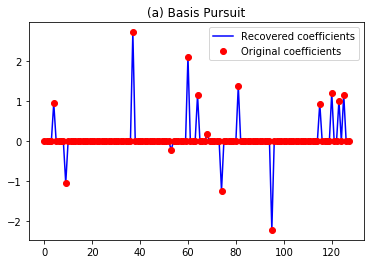

In [4]:
b = A.dot(x0) # signal
x,resid,grad,info = spg_bp(A, b)

plt.figure()
plt.plot(x,'b')
plt.plot(x0,'ro')
plt.legend(('Recovered coefficients','Original coefficients'))
plt.title('(a) Basis Pursuit')

Solve the basis pursuit denoise (BPDN) problem:

$$min. ||x||_1 \quad subject \quad to \quad ||Ax - b||_2 <= 0.1$$

Text(0.5, 1.0, '(b) Basis Pursuit Denoise')

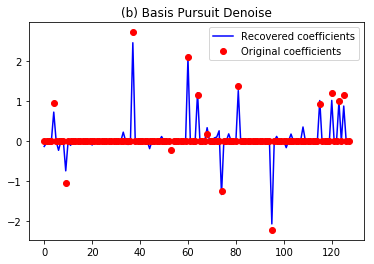

In [5]:
b = A.dot(x0) + np.random.randn(m) * 0.075
sigma = 0.10  #     % Desired ||Ax - b||_2
x,resid,grad,info = spg_bpdn(A, b, sigma)

plt.figure()
plt.plot(x,'b')
plt.plot(x0,'ro')
plt.legend(('Recovered coefficients','Original coefficients'))
plt.title('(b) Basis Pursuit Denoise')

Solve the basis pursuit (BP) problem in COMPLEX variables:

$$min. ||z||_1 \quad subject \quad to \quad  Az = b$$

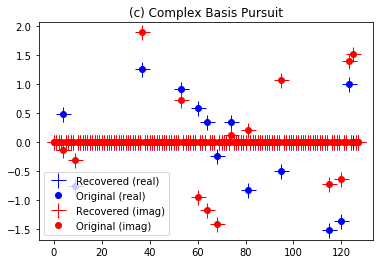

In [6]:
from scipy.sparse.linalg import LinearOperator

class partialFourier(LinearOperator):
    def __init__(self, idx, n):
        self.idx = idx
        self.n = n
        self.shape = (len(idx), n)
        self.dtype = np.complex128
    def _matvec(self, x): 
        # % y = P(idx) * FFT(x)
        z = np.fft.fft(x) / np.sqrt(n)
        return z[idx]
    def _rmatvec(self, x): 
        z = np.zeros(n,dtype=complex)
        z[idx] = x
        return np.fft.ifft(z) * np.sqrt(n)

    
# % Create partial Fourier operator with rows idx
idx = np.random.permutation(n)
idx = idx[0:m]
opA = partialFourier(idx, n)

# % Create sparse coefficients and b = 'A' * z0;
z0 = np.zeros(n,dtype=complex)
z0[p] = np.random.randn(k) + 1j * np.random.randn(k)
b = opA.matvec(z0)

z,resid,grad,info = spg_bp(opA,b)

plt.figure()
plt.plot(z.real,'b+',markersize=15.0)
plt.plot(z0.real,'bo')
plt.plot(z.imag,'r+',markersize=15.0)
plt.plot(z0.imag,'ro')
plt.legend(('Recovered (real)', 'Original (real)', 'Recovered (imag)', 'Original (imag)'))
plt.title('(c) Complex Basis Pursuit');

Sample the Pareto frontier at 100 points:
  
$$phi(tau) = min. ||Ax-b||_2 \quad subject \quad to \quad ||x|| <= \tau$$

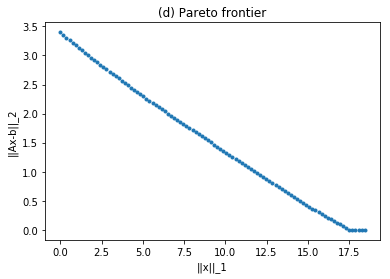

In [7]:
b = A.dot(x0)
x = np.zeros(n)
tau = np.linspace(0, 1.05 * np.linalg.norm(x0, 1), 100)
tau[0] = 1e-10
phi = np.zeros(tau.size)

for i in range(tau.size):
    x,r,grad,info = spgl1(A,b,tau[i],0,x, iterations=1000)
    phi[i] = np.linalg.norm(r)

plt.figure()
plt.plot(tau,phi, '.')
plt.title('(d) Pareto frontier')
plt.xlabel('||x||_1')
plt.ylabel('||Ax-b||_2');

Solve

$$min. ||y||_1 \quad subject \quad  to \quad AW^{-1}y = b$$

and the weighted basis pursuit (BP) problem:

$$min. ||Wx||_1 \quad subject \quad to \quad Ax = b$$

followed by setting $y = Wx$.

Text(0.5, 1.0, '(e) Weighted Basis Pursuit')

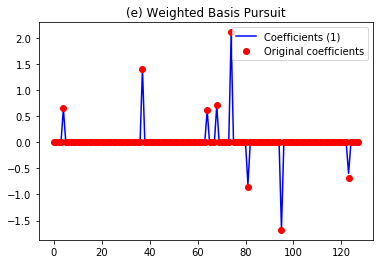

In [8]:
# Sparsify vector x0 a bit more to get exact recovery
k = 9
x0 = np.zeros(n)
x0[p[0:k]] = np.random.randn(k)

# Set up weights w and vector b
w = np.random.rand(n) + 0.1 # Weights
b = A.dot(x0/w)  # Signal

x,resid,grad,info = spg_bp(A, b, **dict(iterations=1000, weights=w))
# Reconstructed solution, with weighting
x1 = x * w

plt.figure()
plt.plot(x1,'b')
plt.plot(x0,'ro')
plt.legend(('Coefficients (1)','Original coefficients'))
plt.title('(e) Weighted Basis Pursuit')

Solve the multiple measurement vector (MMV) problem

$$min. ||Y||_{1,2}  \quad subject \quad to \quad  AW^{-1}Y = B$$

and the weighted MMV problem (weights on the rows of X):

$$min. ||WX||_{1,2} \quad subject \quad to \quad AX = B$$

followed by setting $Y = WX$.

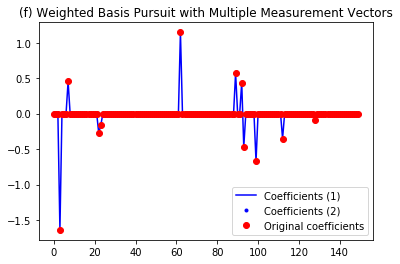

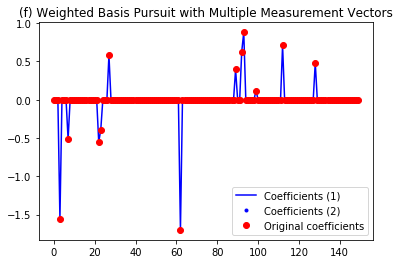

In [9]:
# Create problem
m = 100
n = 150
k = 12
l = 6;
A = np.random.randn(m, n)
p = np.random.permutation(n)[:k]
X0 = np.zeros((n, l))
X0[p, :] = np.random.randn(k, l)

weights = 3 * np.random.rand(n) + 0.1
W = 1/weights * np.eye(n)

B = A.dot(W).dot(X0)

# Solve unweighted version
x_uw, _, _, _ = spg_mmv(A.dot(W), B, 0, **dict(verbosity=1))

# Solve weighted version
x_w, _, _, _ = spg_mmv(A, B, 0, **dict(verbosity=1, weights=weights))
x_w = spdiags(weights, 0, n, n).dot(x_w)

# Plot results
plt.figure()
plt.plot(x_uw[:, 0], 'b-', label='Coefficients (1)')
plt.plot(x_w[:, 0], 'b.', label='Coefficients (2)')
plt.plot(X0[:, 0], 'ro', label='Original coefficients')
plt.legend()
plt.title('(f) Weighted Basis Pursuit with Multiple Measurement Vectors');

plt.figure()
plt.plot(x_uw[:, 1], 'b-', label='Coefficients (1)')
plt.plot(x_w[:, 1], 'b.', label='Coefficients (2)')
plt.plot(X0[:, 1], 'ro', label='Original coefficients')
plt.legend()
plt.title('(f) Weighted Basis Pursuit with Multiple Measurement Vectors');